In [30]:
import os
import cv2
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold


In [2]:
# !zip -r data.zip /kaggle/input/lung-cancer-preprocessed-dataset/lung/Test

In [2]:
sns.set_theme(style="darkgrid", palette="pastel")
color = sns.color_palette(palette = "pastel")

# **Read and exploratory data analysis**

In [3]:
classes = ['Lung Adenocarcinoma', 'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma']

In [4]:
data_dir = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set"

filepaths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds:
    if fold == "colon_image_sets":
        continue
    else:
        foldpath = os.path.join(data_dir, fold)
        flist = os.listdir(foldpath)

        for f in flist:
            f_path = os.path.join(foldpath, f)
            filelist = os.listdir(f_path)

            for file in filelist:
                fpath = os.path.join(f_path, file)
                filepaths.append(fpath)

                if f == "lung_n":
                    labels.append("Lung Benign Tissue")
                elif f == "lung_aca":
                    labels.append("Lung Adenocarcinoma")
                elif f == "lung_scc":
                    labels.append("Lung Squamous Cell Carcinoma")
                    
fpaths = pd.Series(filepaths, name="filepaths")
labels_ = pd.Series(labels, name="labels")

df = pd.concat([fpaths, labels_], axis = 1)


In [5]:
print(df["labels"].value_counts())

labels
Lung Adenocarcinoma             5000
Lung Squamous Cell Carcinoma    5000
Lung Benign Tissue              5000
Name: count, dtype: int64


In [6]:
df

filepaths               labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung Adenocarcinoma
...                                                  ...                  ...
14995  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung Benign Tissue
14996  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung Benign Tissue
14997  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung Benign Tissue
14998  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung Benign Tissue
14999  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung Benign Tissue

[15000 rows x 2 columns]

In [7]:
h = 256
w = 256
def display_images(df):
    plt.figure(figsize=(20, 20))
    for i in range(9):
        id = np.random.randint(0, len(df))
        plt.subplot(3, 3, i + 1)
        image_path = df.iloc[id]['filepaths'] 
        image = cv2.imread(image_path)
        image = cv2.resize(image, (h, w))
        plt.imshow(image)
        class_name=df.iloc[id]['labels']
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

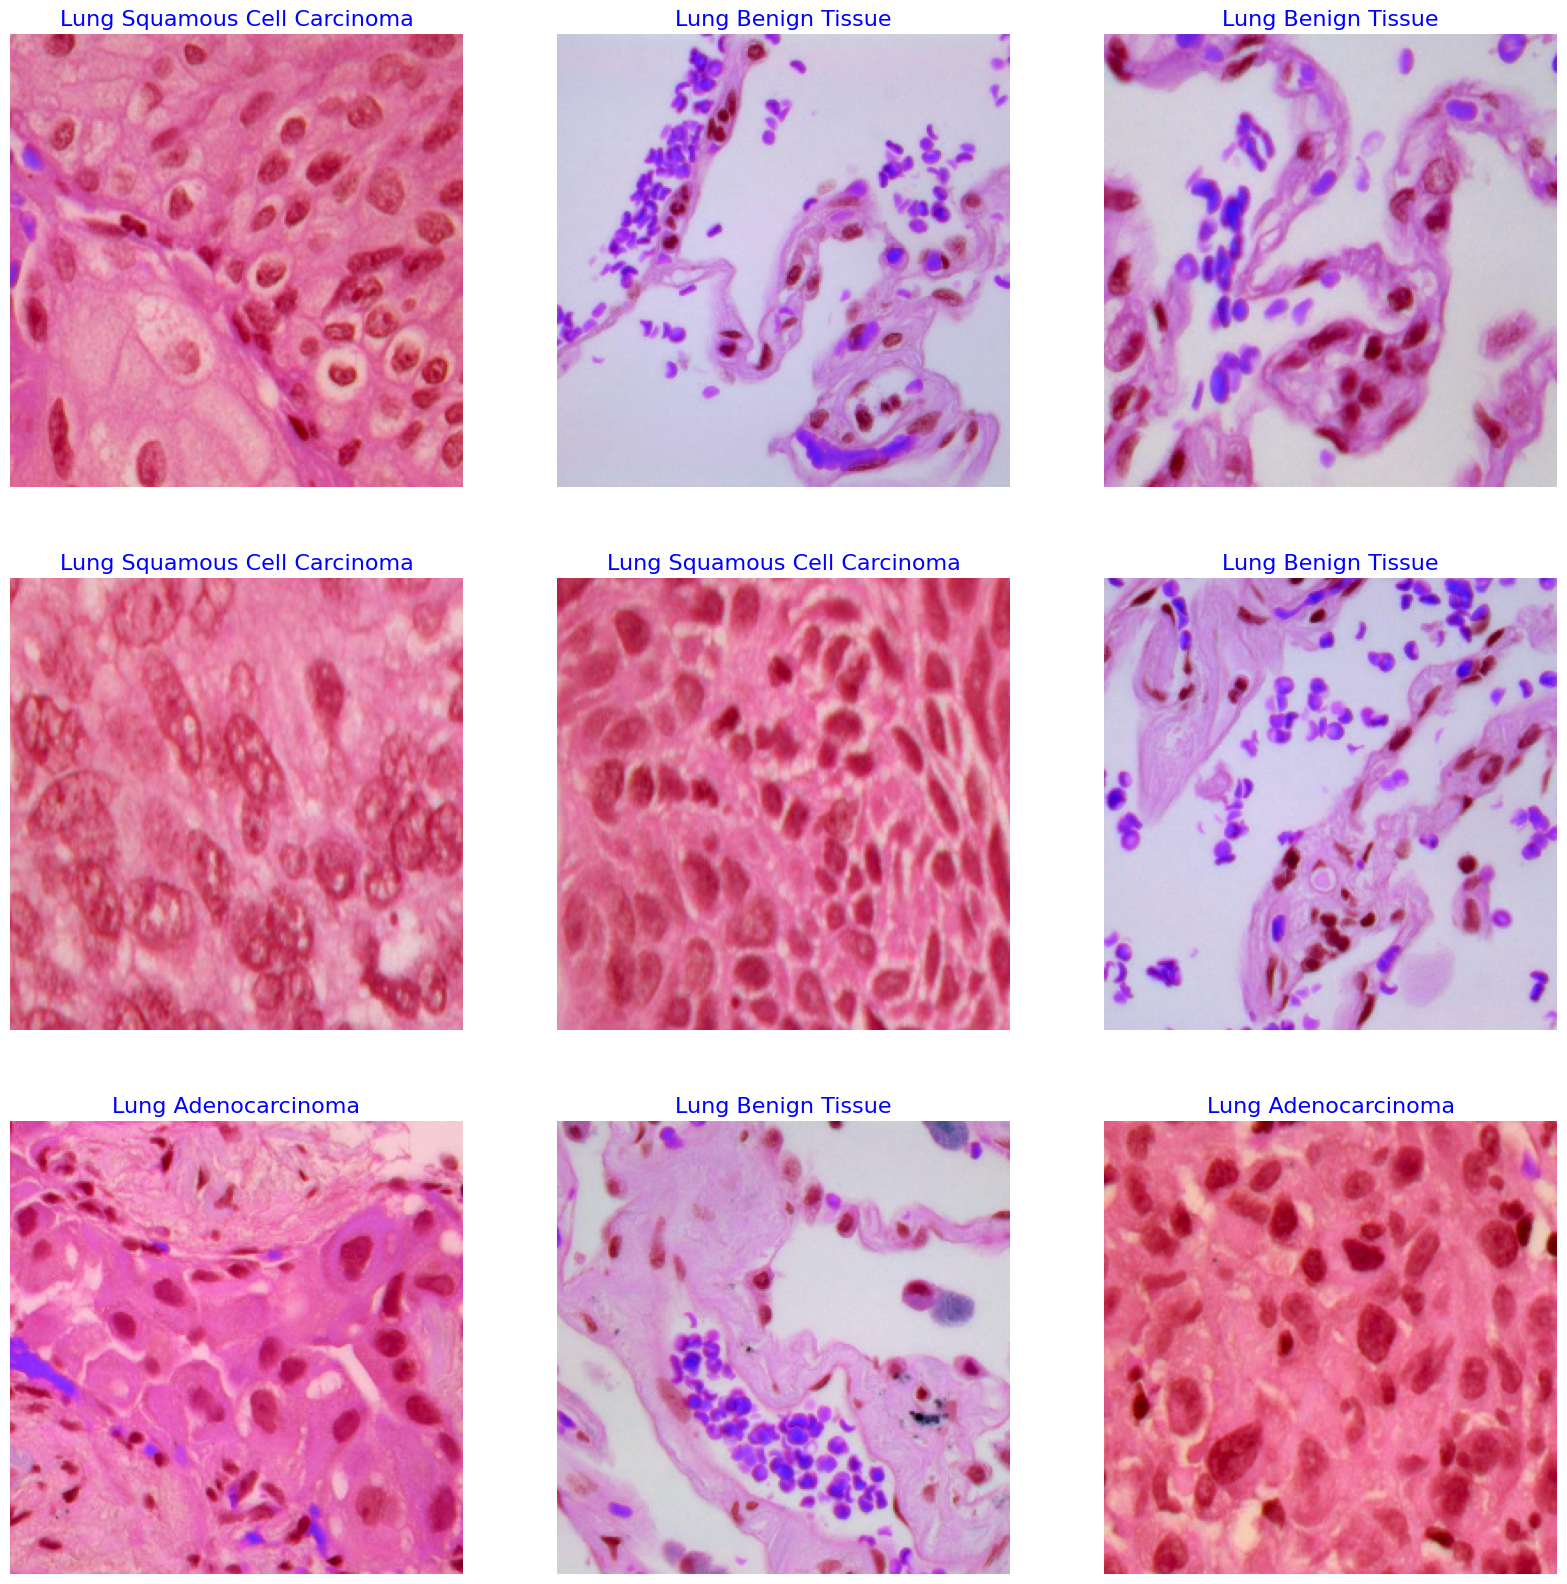

In [8]:
display_images(df)

# **GLCM**

In [9]:
def compute_glcm_features(image):
    distances = [1]  # You can experiment with different distances
    
    # Tính toán với 8 hướng xung quanh (0°, 45°, 90°, 135°, 180°, 225°, 270°, 315°)
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4]
    
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=256,
                        symmetric=True, normed=True)
    
    # Tính các đặc trưng và kết hợp chúng trong một dòng
    features = np.concatenate([
        graycoprops(glcm, 'contrast').ravel(),
        # Tính toán đặc trưng contrast (độ tương phản) của ma trận đồng xuất GLCM. Độ tương phản đo lường mức độ thay đổi trong cường độ pixel, cho biết sự khác biệt giữa các pixel trong ảnh.
        
        graycoprops(glcm, 'energy').ravel(), 
        # ASM Tính toán đặc trưng energy (năng lượng) của GLCM, thường được gọi là Angular Second Moment (ASM). Đặc trưng này cho biết mức độ đồng nhất trong cường độ pixel.
        
        graycoprops(glcm, 'homogeneity').ravel(),
        # Tính toán đặc trưng homogeneity (đồng nhất) của GLCM. Đặc trưng này đo lường mức độ tương đồng giữa các pixel.
        
        graycoprops(glcm, 'correlation').ravel(), 
        # Tính toán đặc trưng correlation (tương quan) của GLCM. Đặc trưng này đo lường mức độ liên quan giữa các pixel.
        
        [-np.sum(glcm * np.log(glcm + 1e-10))]  
        # Tính toán entropy (độ hỗn loạn) của GLCM. Entropy đo lường mức độ không chắc chắn trong phân phối cường độ pixel. Để tránh lỗi số học khi tính log, một hằng số nhỏ (1e-10) được cộng vào GLCM.
    ])
    
    return features

In [10]:
def load_and_compute_glcm_features(paths):
    features = []
    for path in paths:
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        glcm_features = compute_glcm_features(image)
        features.append(glcm_features)
    return np.array(features)

In [11]:
df_glcm = load_and_compute_glcm_features(df['filepaths'])

In [12]:
df_glcm.shape

(15000, 33)

In [16]:
# Tạo tên cột cho DataFrame
columns = []
# Mỗi tập hợp đặc trưng GLCM gồm 4 đặc trưng cho mỗi góc (tổng cộng 8 góc)
# (Contrast, Energy, Homogeneity, Correlation)
for angle in range(8):
    columns.extend([
        f"Contrast_{angle * 45}", 
        f"Energy_{angle * 45}", 
        f"Homogeneity_{angle * 45}", 
        f"Correlation_{angle * 45}"
    ])

# Thêm Entropy, chỉ tính cho một giá trị duy nhất
columns.append("Entropy")

# Tạo DataFrame từ danh sách các đặc trưng với tên cột đã định nghĩa
# Giả sử df_glcm là danh sách hoặc mảng 2D chứa các đặc trưng đã tính toán
df_glcm = pd.DataFrame(df_glcm, columns=columns)

In [17]:
df_glcm['Label'] = df['labels'].values

In [18]:
df_glcm

Contrast_0   Energy_0  Homogeneity_0  Correlation_0  Contrast_45  \
0       13.185351  18.907238       6.346256      18.768228    13.185351   
1       16.696759  21.887739       7.343429      24.978740    16.696759   
2       16.919016  38.993588      22.393803      36.177052    16.919016   
3       22.557270  42.129226      22.461260      44.154910    22.557270   
4       20.439963  42.065419      21.323582      38.307825    20.439963   
...           ...        ...            ...            ...          ...   
14995    9.497705  14.564105       4.717429      12.899327     9.497705   
14996   12.271663  22.835761      10.800477      21.656429    12.271663   
14997    8.521399  16.046015       7.864266      15.322563     8.521399   
14998   15.252268  26.569708      13.715837      28.450709    15.252268   
14999   16.377760  29.797339      14.800194      29.468351    16.377760   

       Energy_45  Homogeneity_45  Correlation_45  Contrast_90  Energy_90  ...  \
0      18.907238        6.346256       18.768228     0.033430   0.030284  ...   
1      21.887739        7.343429       24.978740     0.026258   0.024106  ...   
2      38.993588       22.393803       36.177052     0.032733   0.026081  ...   
3      42.129226       22.461260       44.154910     0.026426   0.022357  ...   
4      42.065419       21.323582       38.307825     0.028602   0.023529  ...   
...          ...             ...             ...          ...        ...  ...   
14995  14.564105        4.717429       12.899327     0.078592   0.070582  ...   
14996  22.835761       10.800477       21.656429     0.068178   0.058085  ...   
14997  16.046015        7.864266       15.322563     0.071060   0.060368  ...   
14998  26.569708       13.715837       28.450709     0.067638   0.055732  ...   
14999  29.797339       14.800194       29.468351     0.081376   0.067708  ...   

       Contrast_270  Energy_270  Homogeneity_270  Correlation_270  \
0          0.994810    0.992560         0.997503         0.992614   
1          0.996000    0.994756         0.998242         0.994016   
2          0.990262    0.977546         0.987103         0.979168   
3          0.992971    0.986874         0.993000         0.986243   
4          0.994125    0.987916         0.993874         0.988996   
...             ...         ...              ...              ...   
14995      0.997058    0.995491         0.998539         0.996006   
14996      0.996022    0.992598         0.996497         0.992980   
14997      0.995926    0.992331         0.996239         0.992676   
14998      0.993957    0.989474         0.994563         0.988729   
14999      0.993442    0.988076         0.994079         0.988208   

       Contrast_315  Energy_315  Homogeneity_315  Correlation_315    Entropy  \
0          0.994810    0.992560         0.997503         0.992614  59.172028   
1          0.996000    0.994756         0.998242         0.994016  62.144958   
2          0.990262    0.977546         0.987103         0.979168  61.416045   
3          0.992971    0.986874         0.993000         0.986243  63.615230   
4          0.994125    0.987916         0.993874         0.988996  63.042528   
...             ...         ...              ...              ...        ...   
14995      0.997058    0.995491         0.998539         0.996006  52.408156   
14996      0.996022    0.992598         0.996497         0.992980  55.364406   
14997      0.995926    0.992331         0.996239         0.992676  52.795193   
14998      0.993957    0.989474         0.994563         0.988729  55.037111   
14999      0.993442    0.988076         0.994079         0.988208  53.108466   

                     Label  
0      Lung Adenocarcinoma  
1      Lung Adenocarcinoma  
2      Lung Adenocarcinoma  
3      Lung Adenocarcinoma  
4      Lung Adenocarcinoma  
...                    ...  
14995   Lung Benign Tissue  
14996   Lung Benign Tissue  
14997   Lung Benign Tissue  
14998   Lung Benign Tissue  
14999   Lung Benign Tiss

In [19]:
strat = df_glcm["Label"]

df_train, df_test = train_test_split(df_glcm,  train_size= 0.8, shuffle= True, random_state=42, stratify= strat)


In [20]:
df_train

Contrast_0   Energy_0  Homogeneity_0  Correlation_0  Contrast_45  \
10497   15.247092  21.685462      12.786132      32.186755    15.247092   
7677     7.811994  12.715769       6.042636      13.336387     7.811994   
13037   10.780773  19.312221       9.921760      20.510015    10.780773   
11670   20.330544  38.254910      18.912041      36.998355    20.330544   
79      19.789626  35.828996      17.398589      35.254261    19.789626   
...           ...        ...            ...            ...          ...   
10013    9.899072  16.490171      11.305518      24.005329     9.899072   
4721     7.465351  10.100753       2.894148       9.699235     7.465351   
4788    14.956478  22.266650       9.057713      23.867704    14.956478   
6253    16.930417  34.822439      17.037363      30.309649    16.930417   
12635   17.675807  36.318996      17.113495      30.532249    17.675807   

       Energy_45  Homogeneity_45  Correlation_45  Contrast_90  Energy_90  ...  \
10497  21.685462       12.786132       32.186755     0.049940   0.042894  ...   
7677   12.715769        6.042636       13.336387     0.049183   0.043156  ...   
13037  19.312221        9.921760       20.510015     0.066392   0.056251  ...   
11670  38.254910       18.912041       36.998355     0.061243   0.051225  ...   
79     35.828996       17.398589       35.254261     0.044366   0.037817  ...   
...          ...             ...             ...          ...        ...  ...   
10013  16.490171       11.305518       24.005329     0.100422   0.083531  ...   
4721   10.100753        2.894148        9.699235     0.038784   0.036104  ...   
4788   22.266650        9.057713       23.867704     0.027917   0.024877  ...   
6253   34.822439       17.037363       30.309649     0.030430   0.024988  ...   
12635  36.318996       17.113495       30.532249     0.061443   0.050852  ...   

       Contrast_270  Energy_270  Homogeneity_270  Correlation_270  \
10497      0.995636    0.993792         0.996340         0.990786   
7677       0.991010    0.985357         0.993039         0.984642   
13037      0.996156    0.993117         0.996465         0.992690   
11670      0.993823    0.988370         0.994250         0.988752   
79         0.990726    0.983217         0.991842         0.983487   
...             ...         ...              ...              ...   
10013      0.995865    0.993111         0.995276         0.989971   
4721       0.996630    0.995438         0.998693         0.995619   
4788       0.994349    0.991584         0.996574         0.990979   
6253       0.991723    0.982973         0.991671         0.985180   
12635      0.994368    0.988419         0.994541         0.990264   

       Contrast_315  Energy_315  Homogeneity_315  Correlation_315    Entropy  \
10497      0.995636    0.993792         0.996340         0.990786  58.536535   
7677       0.991010    0.985357         0.993039         0.984642  53.984897   
13037      0.996156    0.993117         0.996465         0.992690  55.127281   
11670      0.993823    0.988370         0.994250         0.988752  57.546558   
79         0.990726    0.983217         0.991842         0.983487  58.304438   
...             ...         ...              ...              ...        ...   
10013      0.995865    0.993111         0.995276         0.989971  49.856568   
4721       0.996630    0.995438         0.998693         0.995619  56.354894   
4788       0.994349    0.991584         0.996574         0.990979  61.321517   
6253       0.991723    0.982973         0.991671         0.985180  61.438876   
12635      0.994368    0.988419         0.994541         0.990264  57.128085   

                              Label  
10497            Lung Benign Tissue  
7677   Lung Squamous Cell Carcinoma  
13037            Lung Benign Tissue  
11670            Lung Benign Tissue  
79              Lung Adenocarcinoma  
...                             ...  
10013            Lung Benign Tissue  
4721            Lung Adenocarcinoma  
4

In [21]:
df_test

Contrast_0   Energy_0  Homogeneity_0  Correlation_0  Contrast_45  \
11735    7.144575  11.317009       6.653721      15.140166     7.144575   
4341    12.201876  19.046161       6.917897      17.982354    12.201876   
1852     4.661088   7.208880       3.685678       8.586943     4.661088   
3072     9.780388  18.519139       7.441209      14.577743     9.780388   
2237    14.281550  30.828962      14.353335      24.179332    14.281550   
...           ...        ...            ...            ...          ...   
5166    11.122194  18.857089       9.030615      19.578182    11.122194   
7094    16.627103  34.114136      14.028744      23.992755    16.627103   
9950    14.105876  31.909835      20.964553      34.313460    14.105876   
13862    9.620219  12.445082       4.603579      15.083865     9.620219   
2690    11.871272  18.087313       5.637775      15.797615    11.871272   

       Energy_45  Homogeneity_45  Correlation_45  Contrast_90  Energy_90  ...  \
11735  11.317009        6.653721       15.140166     0.092357   0.080281  ...   
4341   19.046161        6.917897       17.982354     0.031187   0.027551  ...   
1852    7.208880        3.685678        8.586943     0.095708   0.082892  ...   
3072   18.519139        7.441209       14.577743     0.053193   0.044848  ...   
2237   30.828962       14.353335       24.179332     0.030685   0.025134  ...   
...          ...             ...             ...          ...        ...  ...   
5166   18.857089        9.030615       19.578182     0.039999   0.035117  ...   
7094   34.114136       14.028744       23.992755     0.037032   0.031396  ...   
9950   31.909835       20.964553       34.313460     0.030889   0.024949  ...   
13862  12.445082        4.603579       15.083865     0.103727   0.094302  ...   
2690   18.087313        5.637775       15.797615     0.061947   0.054985  ...   

       Contrast_270  Energy_270  Homogeneity_270  Correlation_270  \
11735      0.997067    0.995352         0.997268         0.993782   
4341       0.996665    0.994797         0.998109         0.995087   
1852       0.998279    0.997337         0.998640         0.996828   
3072       0.997215    0.994727         0.997881         0.995849   
2237       0.994719    0.988600         0.994693         0.991059   
...             ...         ...              ...              ...   
5166       0.991753    0.986013         0.993299         0.985478   
7094       0.989419    0.978279         0.991065         0.984724   
9950       0.992856    0.983839         0.989380         0.982621   
13862      0.996527    0.995509         0.998338         0.994557   
2690       0.997067    0.995531         0.998607         0.996097   

       Contrast_315  Energy_315  Homogeneity_315  Correlation_315    Entropy  \
11735      0.997067    0.995352         0.997268         0.993782  50.449298   
4341       0.996665    0.994797         0.998109         0.995087  60.227771   
1852       0.998279    0.997337         0.998640         0.996828  49.696995   
3072       0.997215    0.994727         0.997881         0.995849  57.369748   
2237       0.994719    0.988600         0.994693         0.991059  61.340739   
...             ...         ...              ...              ...        ...   
5166       0.991753    0.986013         0.993299         0.985478  57.614640   
7094       0.989419    0.978279         0.991065         0.984724  58.495744   
9950       0.992856    0.983839         0.989380         0.982621  61.831611   
13862      0.996527    0.995509         0.998338         0.994557  47.969887   
2690       0.997067    0.995531         0.998607         0.996097  56.337433   

                              Label  
11735            Lung Benign Tissue  
4341            Lung Adenocarcinoma  
1852            Lung Adenocarcinoma  
3072            Lung Adenocarcinoma  
2237            Lung Adenocarcinoma  
...                             ...  
5166   Lung Squamous Cell Carcinoma  
7094   Lung Squamous Cell Carcinoma  
9

In [22]:
X_train = df_train.iloc[:, :-1].values
X_test = df_test.iloc[:, :-1].values

In [23]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(df_train['Label'])
y_test_encoded = label_encoder.transform(df_test['Label'])
print("Classes:", label_encoder.classes_)

Classes: ['Lung Adenocarcinoma' 'Lung Benign Tissue' 'Lung Squamous Cell Carcinoma']


# **Confusion Matrix**

In [24]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = 'd'
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black",
                 fontsize=10)

    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)
    plt.title('Confusion Matrix', fontsize=16)
    plt.tight_layout()


In [89]:
from sklearn.feature_selection import (SelectKBest, 
                                       VarianceThreshold, 
                                       SelectFromModel, 
                                       mutual_info_classif,
                                       RFE)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV, ElasticNetCV
from sklearn.metrics import f1_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.preprocessing import StandardScaler

X_train_temp = X_train
X_test_temp = X_test
n = 16
max_iter = 2000

# Standardize features
scaler = StandardScaler()
X_train_temp = scaler.fit_transform(X_train_temp)
X_test_temp = scaler.transform(X_test_temp)


# 3. Mutual Information
print("3. Mutual Information")
selector = SelectKBest(mutual_info_classif, k=n)
X_train_mi = selector.fit_transform(X_train_temp, y_train_encoded)
X_test_mi = selector.transform(X_test_temp)

# 5. Recursive Feature Elimination (RFE)
print("5. Recursive Feature Elimination (RFE)")
rfe_selector = RFE(estimator=LogisticRegression(max_iter=max_iter), n_features_to_select=n)
X_train_rfe = rfe_selector.fit_transform(X_train_temp, y_train_encoded)
X_test_rfe = rfe_selector.transform(X_test_temp)

# 7. Ridge Regression
# Note that Ridge regression does not inherently select features, but we can use it alongside SelectFromModel
print("7. Ridge Regression")
ridge_selector = SelectFromModel(RidgeClassifier(alpha=1.0))
X_train_ridge = ridge_selector.fit_transform(X_train_temp, y_train_encoded)
X_test_ridge = ridge_selector.transform(X_test_temp)

# 9. Random Forest
print("9. Random Forest")
rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
X_train_rf = rf_selector.fit_transform(X_train_temp, y_train_encoded)
X_test_rf = rf_selector.transform(X_test_temp)

# 10. GBM
print("10. GBM")
gbm_selector = SelectFromModel(GradientBoostingClassifier(n_estimators=100, random_state=42))
X_train_gbm = gbm_selector.fit_transform(X_train_temp, y_train_encoded)
X_test_gbm = gbm_selector.transform(X_test_temp)

# 11. Factor Analysis
print("11. Factor Analysis")
fa_transformer = FactorAnalysis(n_components=n, random_state=42)
X_train_fa = fa_transformer.fit_transform(X_train_temp)
X_test_fa = fa_transformer.transform(X_test_temp)

# 11. PCA
print("12. PCA")
pca_transformer = PCA(n_components=n)
X_train_pca = pca_transformer.fit_transform(X_train_temp)
X_test_pca = pca_transformer.transform(X_test_temp)

# To evaluate:
def evaluate_model(X_train, X_test, y_train, y_test, description):
    # Using Logistic Regression as a simple classifier
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    f1 = f1_score(y_test, predictions, average='micro')
    print(f'F1-score using {description}: {f1:.4f}')

# Now, evaluate each method
evaluate_model(X_train_mi, X_test_mi, y_train_encoded, y_test_encoded, 'Mutual Information')
evaluate_model(X_train_rfe, X_test_rfe, y_train_encoded, y_test_encoded, 'Recursive Feature Elimination (RFE)')
evaluate_model(X_train_ridge, X_test_ridge, y_train_encoded, y_test_encoded, 'Ridge Regression')
evaluate_model(X_train_rf, X_test_rf, y_train_encoded, y_test_encoded, 'Random Forest')
evaluate_model(X_train_gbm, X_test_gbm, y_train_encoded, y_test_encoded, 'GBM')
evaluate_model(X_train_fa, X_test_fa, y_train_encoded, y_test_encoded, 'Factor Analysis')
evaluate_model(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded, 'PCA')



3. Mutual Information
5. Recursive Feature Elimination (RFE)
7. Ridge Regression
9. Random Forest
10. GBM
11. Factor Analysis
12. PCA
F1-score using Mutual Information: 0.8120
F1-score using Recursive Feature Elimination (RFE): 0.8717
F1-score using Ridge Regression: 0.8113
F1-score using Random Forest: 0.8550
F1-score using GBM: 0.8570
F1-score using Factor Analysis: 0.8783
F1-score using PCA: 0.8730


# **Logistic Regression**

In [95]:
from sklearn.linear_model import LogisticRegression
def tuning(X_train_type):
    # Đặt phương pháp khởi tạo
    with joblib.parallel_backend('threading', n_jobs=4):
        # Step 3: Define a pipeline for preprocessing and training the model
        lr_pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Feature scaling (optional)
            ('classifier', LogisticRegression())
        ])
    
        # Step 4: Define hyperparameters to search over
        
        param_grid_lr = [
            {'classifier__penalty': ['l1'], 
             'classifier__C': [0.1, 1],
             'classifier__solver': ['liblinear', 'saga'], 
             'classifier__max_iter': [4000, 5000, 6000],
             'classifier__multi_class': ['auto', 'ovr']},  # Remove 'multinomial' for liblinear
    
            {'classifier__penalty': ['l2'], 
             'classifier__C': [0.1, 1],
             'classifier__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'], 
             'classifier__max_iter': [4000, 5000, 6000],
             'classifier__multi_class': ['auto', 'ovr', 'multinomial']}
        ]
    
        # Step 5: Perform grid search cross-validation with k-fold cross-validation
        grid_search_lr = GridSearchCV(lr_pipeline, param_grid_lr, n_jobs=4)
        grid_search_lr.fit(X_train_type, y_train_encoded)
    
    # Step 6: Get the best model and evaluate its performance
    best_model_lr = grid_search_lr.best_estimator_
    mean_cv_accuracy_lr = grid_search_lr.best_score_
    print("Best Model Parameters (LR):", grid_search_lr.best_params_)
    print("Mean Cross-Validation Accuracy (LR):", mean_cv_accuracy_lr)

    return best_model_lr

In [96]:
best_model_lr = tuning(X_train_pca)

Best Model Parameters (LR): {'classifier__C': 1, 'classifier__max_iter': 4000, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Mean Cross-Validation Accuracy (LR): 0.8842500000000001


In [97]:
best_model_lr_rfe = tuning(X_train_rfe)

Best Model Parameters (LR): {'classifier__C': 1, 'classifier__max_iter': 4000, 'classifier__multi_class': 'auto', 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Mean Cross-Validation Accuracy (LR): 0.873


In [98]:
y_pred_lr = best_model_lr.predict(X_test_pca)

# **Confusion Matrix LR**

Accuracy_Score:  0.885


<Figure size 800x600 with 0 Axes>

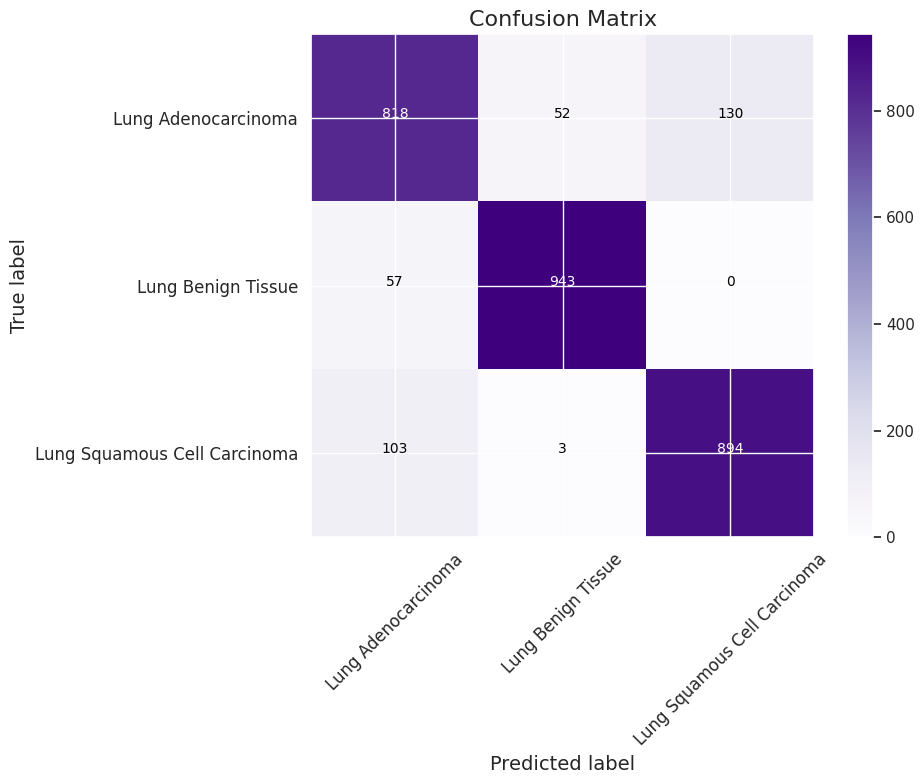

In [99]:
# Example confusion matrix
print("Accuracy_Score: ", accuracy_score(y_test_encoded, y_pred_lr))
cm_lr = confusion_matrix(y_test_encoded, y_pred_lr)
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm_lr, classes)
plt.show()

# **Classification Report LR**

In [101]:
# Compute the classification report
report_lr = classification_report(y_test_encoded, y_pred_lr)
print("Classification Report:")
print(report_lr)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1000
           1       0.94      0.94      0.94      1000
           2       0.87      0.89      0.88      1000

    accuracy                           0.89      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.89      0.88      3000



In [102]:
from joblib import dump, load

# Lưu mô hình
dump(scaler, 'scaler.joblib')
dump(pca_transformer, 'pca_transformer.joblib')
dump(best_model_lr, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [105]:
# Tải mô hình
scaler_loaded = load('/kaggle/working/scaler.joblib')
pca_loaded = load('/kaggle/working/pca_transformer.joblib')
lr_loaded = load('/kaggle/working/logistic_regression_model.joblib')

In [113]:
def predict_image(path_imgs, labels, scaler, pca, model):
    X = load_and_compute_glcm_features(path_imgs)
    y = labels
    X = scaler.transform(X)
    X = pca.transform(X)
    
    y_pred = model.predict(X)
    
    # Tạo tên cột cho DataFrame
    columns = []
    # Mỗi tập hợp đặc trưng GLCM gồm 4 đặc trưng cho mỗi góc (tổng cộng 8 góc)
    # (Contrast, Energy, Homogeneity, Correlation)
    for i in range(n):
        columns.extend([
            f"Feature_{i}", 
        ])
    df_X = pd.DataFrame(X, columns=columns)
    
    # In DataFrame ra màn hình
    print(df_X)
    
    for i, path_img in enumerate(path_imgs):
        img = cv2.imread(path_img)
        img = cv2.resize(img, (h, w))
        
        plt.figure(figsize=(12,12))
        plt.imshow(img)
        plt.title(f"Label: {y}")
        plt.xlabel(f"Predicted label: {classes[y_pred[0]]}")
        plt.show()

   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0  -2.701108   -4.09449   0.226621  -0.161341   -0.24306  -0.623647   

   Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  \
0   0.066501  -0.121786  -0.033772   0.028179   -0.094949    0.005039   

   Feature_12  Feature_13  Feature_14  Feature_15  
0   -0.024728    0.014445    0.001426    0.000464  


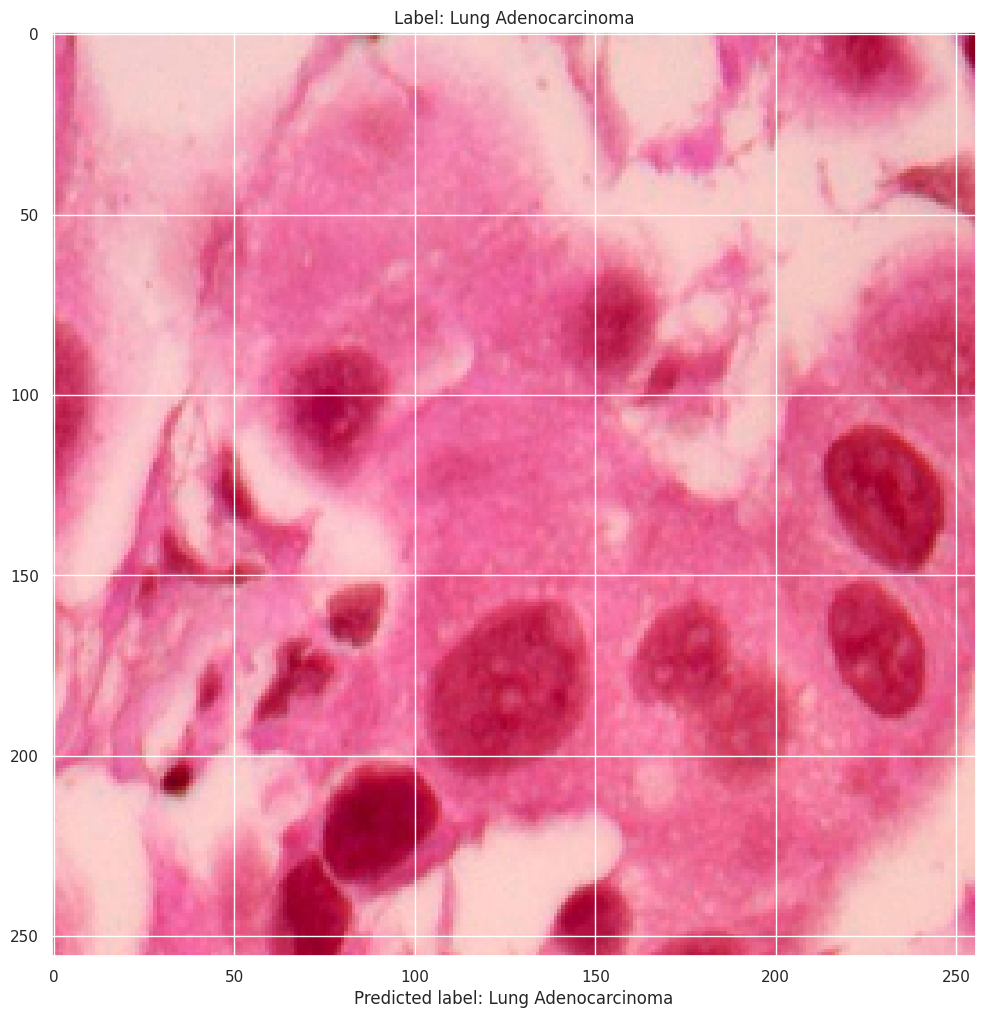

In [114]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4376.jpeg"], "Lung Adenocarcinoma", scaler_loaded, pca_loaded, lr_loaded)

   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   -6.36337   0.759839  -0.592454   0.011085   0.768242   -0.17706   

   Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  \
0   -0.02675  -0.006525  -0.057717  -0.124736    0.104106   -0.128649   

   Feature_12  Feature_13  Feature_14  Feature_15  
0   -0.029964   -0.017107    0.005936   -0.039923  


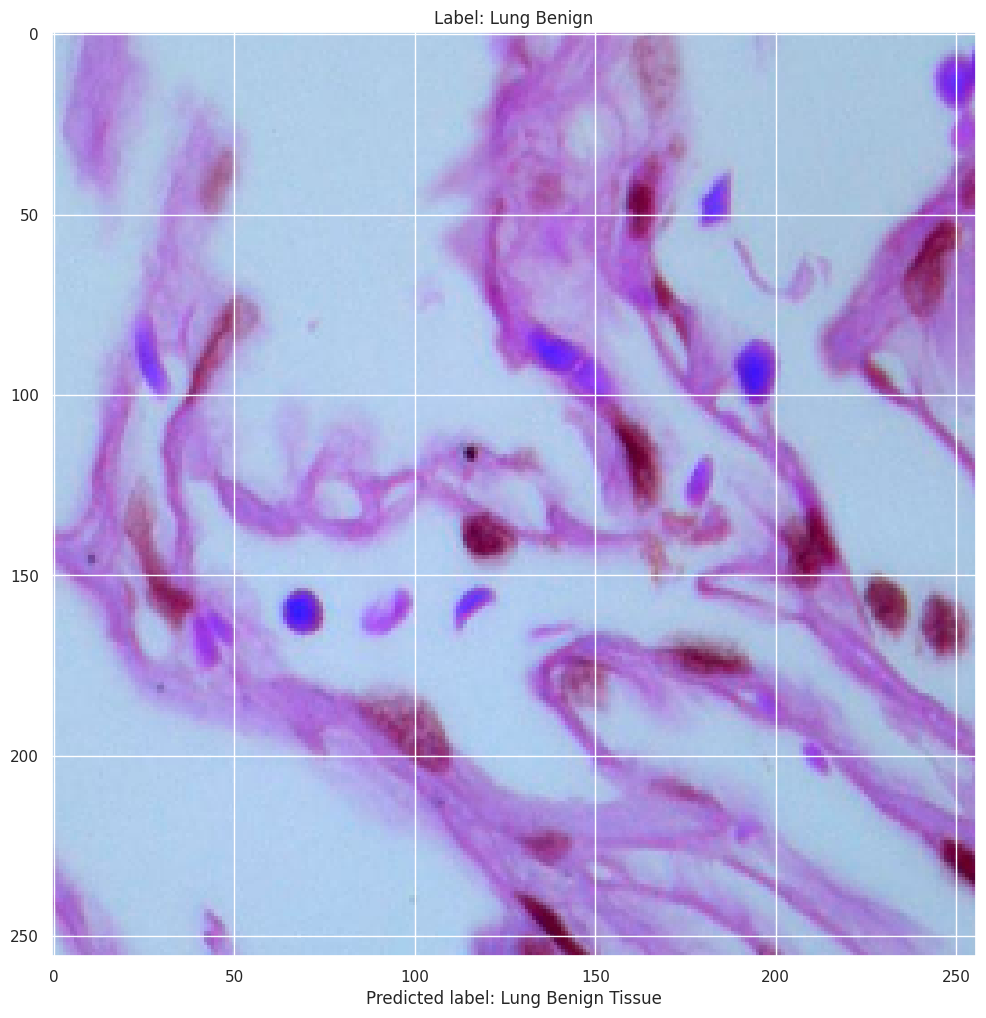

In [115]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4376.jpeg"], "Lung Benign", scaler_loaded, pca_loaded, lr_loaded)

   Feature_0  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0   6.180013   0.268143  -1.095665   0.595536   0.513547   0.499261   

   Feature_6  Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  \
0  -0.146312   -0.04844  -0.111981  -0.062373   -0.069544    0.000513   

   Feature_12  Feature_13  Feature_14  Feature_15  
0    -0.00001    0.030587    -0.00546   -0.000901  


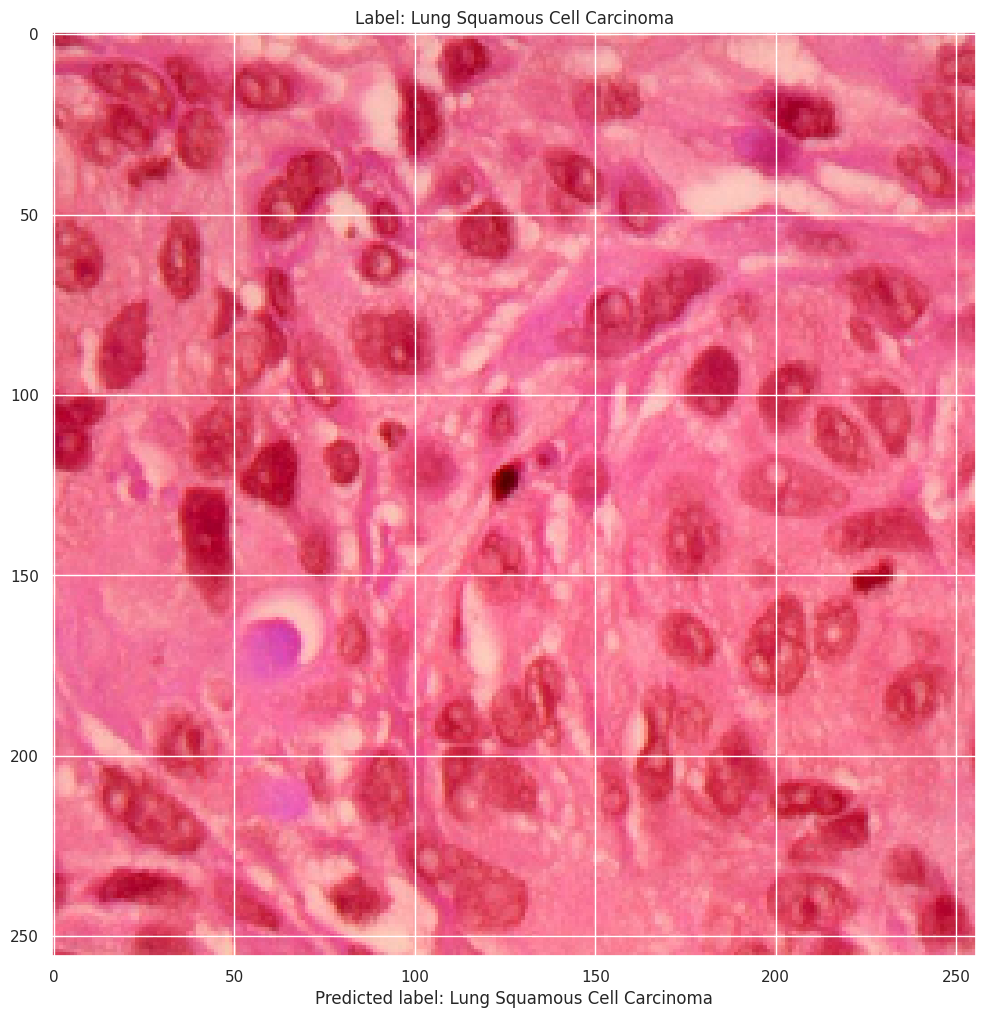

In [116]:
predict_image(["/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4376.jpeg"], "Lung Squamous Cell Carcinoma", scaler_loaded, pca_loaded, lr_loaded)

In [117]:
def read_data_test(data_dir):
    filepaths = []  # Sửa tên biến
    filelist = os.listdir(data_dir)

    for file in filelist:
        fpath = os.path.join(data_dir, file)  # Sửa biến từ f_path thành data_dir
        filepaths.append(fpath)

    data = pd.DataFrame(filepaths, columns=["filepaths"])  # Sửa định nghĩa cột thành danh sách
    
    return data


In [123]:
def predict(data, label, scaler, pca, model, classes):
    # Tải và tính toán các đặc trưng GLCM
    X = load_and_compute_glcm_features(data['filepaths'])
    X = scaler.transform(X)
    X = pca.transform(X)
    # Dự đoán nhãn
    y_pred = model.predict(X)
    count = 0
    # Lặp qua từng ảnh và so sánh với nhãn thực tế
    for i, path_img in enumerate(data['filepaths']):
        if classes[y_pred[i]] != label:
            print(path_img)
            count += 1
    print(count)


In [119]:
data_adenocarcinoma = read_data_test("/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma")
data_benign = read_data_test("/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign")
data_squamous_carcinoma = read_data_test("/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma")

In [125]:
predict(data_adenocarcinoma, "Lung Adenocarcinoma", scaler_loaded, pca_loaded, lr_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4810.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4764.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4839.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4614.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4517.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4779.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4689.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4597.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4565.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4600.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/adenocarcinoma/lungaca4541.jpeg
/kaggle/input/lung-ca

In [127]:
predict(data_benign, "Lung Benign Tissue", scaler_loaded, pca_loaded, lr_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4714.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4906.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4471.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4507.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4843.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4715.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4917.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4737.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4574.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4745.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4579.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/benign/lungn4993.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/

In [129]:
predict(data_squamous_carcinoma, "Lung Squamous Cell Carcinoma", scaler_loaded, pca_loaded, lr_loaded, classes)

/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4938.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4784.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4497.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4943.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4756.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4418.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4635.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4540.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4894.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carcinoma/lungscc4861.jpeg
/kaggle/input/lung-cancer-preprocessed-dataset/lung/Test/squamous_carc

# Code xử lý datatest. Xóa bớt 1 số ảnh trong bộ dữ liệu test

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from joblib import load
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

classes = ['Lung Adenocarcinoma', 'Lung Benign Tissue', 'Lung Squamous Cell Carcinoma']
n = 16 # Số đặc trưng sau khi giảm chiều

def compute_glcm_features(image):

    # Chuyển đổi ảnh sang grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Tính toán với 8 hướng xung quanh (0°, 45°, 90°, 135°, 180°, 225°, 270°, 315°)
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2, 7*np.pi/4]

    # Tính GLCM và các đặc trưng trực tiếp
    glcm = graycomatrix(image, distances=[1], angles=angles, levels=256, symmetric=True, normed=True)
    
    # Tính các đặc trưng và kết hợp chúng trong một dòng
    features = np.concatenate([
        graycoprops(glcm, 'contrast').ravel(),
        # Tính toán đặc trưng contrast (độ tương phản) của ma trận đồng xuất GLCM. Độ tương phản đo lường mức độ thay đổi trong cường độ pixel, cho biết sự khác biệt giữa các pixel trong ảnh.
        
        graycoprops(glcm, 'energy').ravel(), 
        # ASM Tính toán đặc trưng energy (năng lượng) của GLCM, thường được gọi là Angular Second Moment (ASM). Đặc trưng này cho biết mức độ đồng nhất trong cường độ pixel.
        
        graycoprops(glcm, 'homogeneity').ravel(),
        # Tính toán đặc trưng homogeneity (đồng nhất) của GLCM. Đặc trưng này đo lường mức độ tương đồng giữa các pixel.
        
        graycoprops(glcm, 'correlation').ravel(), 
        # Tính toán đặc trưng correlation (tương quan) của GLCM. Đặc trưng này đo lường mức độ liên quan giữa các pixel.
        
        [-np.sum(glcm * np.log(glcm + 1e-10))]  
        # Tính toán entropy (độ hỗn loạn) của GLCM. Entropy đo lường mức độ không chắc chắn trong phân phối cường độ pixel. Để tránh lỗi số học khi tính log, một hằng số nhỏ (1e-10) được cộng vào GLCM.
    ])
    
    return features

def predict_image(image,scaler, pca, model):
    X = compute_glcm_features(image)
    
    X = scaler.transform([X])
    X = pca.transform(X)
    
    y_pred = model.predict(X)
    
    # Tạo tên cột cho DataFrame
    columns = []
    # Mỗi tập hợp đặc trưng GLCM gồm 4 đặc trưng cho mỗi góc (tổng cộng 8 góc)
    # (Contrast, Energy, Homogeneity, Correlation)
    for i in range(n):
        columns.extend([
            f"Feature_{i}", 
        ])
    df_X = pd.DataFrame(X, columns=columns)
    
    # # In DataFrame ra màn hình
    # print(df_X)
    return y_pred

scaler_loaded = load('scaler.joblib')
pca_loaded = load('pca_transformer.joblib')
lr_loaded = load('logistic_regression_model.joblib')

def processing(data_dir, num):
    count = 0
    # Lấy tên folder
    label = os.path.basename(data_dir)
    print(label)
    for file in os.listdir(data_dir):
        if count < num:
            fpath = os.path.join(data_dir, file)
            image = cv2.imread(fpath)
            # Dự đoán nhãn
            y_pred = predict_image(image, scaler_loaded, pca_loaded, lr_loaded)

            if classes[y_pred[0]] != label:
                count += 1
                os.remove(fpath)
        else: return


processing("datatest/Lung Adenocarcinoma", 69)
processing("datatest/Lung Benign Tissue", 2)
processing("datatest/Lung Squamous Cell Carcinoma", 16)